# Import packages

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()
import datetime as dt
from datetime import timedelta
from sklearn.cluster import KMeans
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import neighbors, datasets
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score
from xgboost import XGBClassifier

# Read files

In [3]:
# Data used to build the model
df_old = pd.read_excel("5-17 to 9-20.xlsx")
df_new = pd.read_excel("9-21 to 10-24.xlsx")
df_new2 = pd.read_excel("10-25 to 12-5.xlsx")
weather = pd.read_excel("weather.xlsx")
df = pd.concat([df_old, df_new, df_new2])

In [4]:
# Change the data file to be predicted here
file="10-25 to 12-5.xlsx"

In [5]:
df_backup = df

In [6]:
df_backup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103862 entries, 0 to 22118
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Run Name         83230 non-null   float64       
 1   Ev Order         103862 non-null  int64         
 2   Client Id        103862 non-null  int64         
 3   Date             103862 non-null  datetime64[ns]
 4   Creation Date    103862 non-null  datetime64[ns]
 5   Modified Date    103862 non-null  datetime64[ns]
 6   Modified Time    103862 non-null  object        
 7   Request          103862 non-null  int64         
 8   Negotiated       103862 non-null  int64         
 9   Subtype          103862 non-null  object        
 10  Sched Status     103862 non-null  int64         
 11  Purpose          103862 non-null  object        
 12  Pass On          103561 non-null  object        
 13  Space On         103561 non-null  object        
 14  Direct Distance  1038

# Data preprocessing

In [7]:
weather = weather.replace("T", 0)
weather = weather.replace("M", 0)

In [8]:
weather.head()

,Date,Max_temp,Min_temp,Avg_temp,temp_departure,HDD,CDD,Precipitation,New_snow,Snow_depth
0,2021-05-01,59,33,46.0,-7.5,19,0,0.00,0.0,0
1,2021-05-02,62,50,56.0,2.1,9,0,0.03,0.0,0
2,2021-05-03,68,45,56.5,2.2,8,0,0.03,0.0,0
3,2021-05-04,71,45,58.0,3.3,7,0,0.07,0.0,0
4,2021-05-05,57,47,52.0,-3.1,13,0,0.00,0.0,0


## Missing values

In [9]:
df['Run Name'] = df['Run Name'].fillna(0)

In [10]:
df['Direct Distance'] = [float(d.replace('mi','')) for d in df['Direct Distance']]

In [11]:
df.isnull().sum()

Run Name             0
Ev Order             0
Client Id            0
Date                 0
Creation Date        0
Modified Date        0
Modified Time        0
Request              0
Negotiated           0
Subtype              0
Sched Status         0
Purpose              0
Pass On            301
Space On           301
Direct Distance      0
Pick City            0
Pick Zip           328
Pick Poly            0
Drop City            0
Drop Zip           428
Drop Poly            0
dtype: int64

In [12]:
df=df.dropna()

In [13]:
df = df[(df.Request != -1)]

# Feature engineering

In [14]:
df['Run_Month'] = pd.DatetimeIndex(df['Date']).month
df['Run_Day'] = pd.DatetimeIndex(df['Date']).day
df['Run_Year'] = pd.DatetimeIndex(df['Date']).year
df['Run_weekday'] = df['Date'].dt.dayofweek
df['Run_weekday'] = df['Run_weekday'] + 1

In [15]:
def weekend(x):
    if x == 1 or x == 2 or x== 3 or x==4 or x==5:
        return 0
    else:
        return 1

In [16]:
df['is_weekend'] = df['Run_weekday'].apply(weekend)

In [17]:
df = df.rename(columns={"Creation Date":"Creation_Date"})
diff = (pd.to_datetime(df.Date) - pd.to_datetime(df.Creation_Date)).dt.days
df['diff']=diff


In [18]:
df = df[(df["diff"] < 8 )]

In [19]:
def cancel(x):
    
    if x == 1 or x == 4 or x== 20 or x==21 or x==30 or x==32 or x==42:
        return 0
    else:
        return 1

In [20]:
df['canceled'] = df['Sched Status'].apply(cancel)

In [21]:
df['RequestInHour'] = [math.floor(i/3600) for i in df['Request']]

In [22]:
df['RequestInHour'].value_counts()

15    11939
14    10042
8      9099
13     8944
12     8724
11     8352
9      7532
10     7274
7      6062
16     5672
6      4864
17     4110
5      2287
18     2192
19     2028
20     1674
21     1149
22      446
23      360
4         2
0         1
1         1
Name: RequestInHour, dtype: int64

In [23]:
df['Client Id'].nunique()

1533

In [24]:
a = df.groupby(['Client Id'])['Client Id'].count()
count = a.to_frame()
count=count.rename(columns={'Client Id': 'freq'}) 
count["cancel_freq"] = [df.loc[(df['canceled']==1) & (df['Client Id']==i)].count()[0] for i in count.index.values.tolist()]
count['cancel_rate'] = count['cancel_freq'] / count['freq']
count['client_id'] = count.index.values.tolist()
count.sort_values("cancel_rate", ascending=0)

,freq,cancel_freq,cancel_rate,client_id
Client Id,,,,
140,2,2,1.0,140
3115,2,2,1.0,3115
13004,1,1,1.0,13004
13058,2,2,1.0,13058
20460,2,2,1.0,20460
...,...,...,...,...
15467,12,0,0.0,15467
15549,2,0,0.0,15549
15565,3,0,0.0,15565


In [25]:
count.describe()

,freq,cancel_freq,cancel_rate,client_id
count,1533.000000,1533.000000,1533.000000,1533.000000
mean,67.028050,13.187215,0.230252,16003.693412
std,85.346092,23.231260,0.233713,4887.131762
min,1.000000,0.000000,0.000000,140.000000
25%,6.000000,1.000000,0.046784,13524.000000
50%,29.000000,5.000000,0.167155,17593.000000
75%,98.000000,15.000000,0.333333,19783.000000
max,533.000000,346.000000,1.000000,20959.000000


In [26]:
df = df.rename(columns={"Pass On":"Pass_On"})

In [27]:
df["Pass_On"] = df.Pass_On.astype(str)

In [28]:
def numOfPCA(df):
    if "PCA1" in df["Pass_On"]:
        return 1
    else:
        return 0
    
def numOfChild(df):
    if '2GU1' in df["Pass_On"]:
        return 1
    elif '2GU2' in df["Pass_On"]:
        return 2
    else:
        return 0
    
def numOfCLI(df):
    if "CLI1" in df["Pass_On"]:
        return 1
    elif "CLI2" in df["Pass_On"]:
        return 2
    elif "CLI3" in df["Pass_On"]:
        return 3
    elif "CLI4" in df["Pass_On"]:
        return 4
    elif "CLI5" in df["Pass_On"]:
        return 5
    else:
        return 0
    
def numOf1GU(df):
    if "1GU1" in df["Pass_On"]:
        return 1
    elif "1GU2" in df["Pass_On"]:
        return 2
    elif "1GU3" in df["Pass_On"]:
        return 3
    elif "1GU4" in df["Pass_On"]:
        return 4
    elif "1GU5" in df["Pass_On"]:
        return 5
    else:
        return 0

In [29]:
df["num_PCA"] = df.apply(numOfPCA, axis = 1)
df["num_child"] = df.apply(numOfChild, axis = 1)
df["num_CLI"] = df.apply(numOfCLI, axis = 1)
df["num_1GU"] = df.apply(numOf1GU, axis = 1)

In [30]:
sum = df["num_PCA"] + df["num_child"] + df["num_CLI"] + df["num_1GU"]
df["total_pass"] = sum

In [31]:
df = df.rename(columns={"Space On":"Space_On"})
df["Space_On"] = df.Space_On.astype(str)

In [32]:
def needLift(df):
        if "AL" in df["Space_On"]:
            return 1
        elif "WH" in df["Space_On"]:
            return 1
        elif "XW" in df["Space_On"]:
            return 1
        elif "SC" in df["Space_On"]:
            return 1
        else:
            return 0

In [33]:
df["need_lift"] = df.apply(needLift, axis = 1)

In [34]:
df.groupby("need_lift").mean()

,Run Name,Ev Order,Client Id,Request,Negotiated,Sched Status,Direct Distance,Pick Zip,Pick Poly,Drop Zip,...,Run_weekday,is_weekend,diff,canceled,RequestInHour,num_PCA,num_child,num_CLI,num_1GU,total_pass
need_lift,,,,,,,,,,,,,,,,,,,,,
0,139.881471,4.141414e+07,15475.745751,44176.442026,44252.904614,7.589640,5.367935,14597.588495,11313.13729,14597.123862,...,3.398770,0.104699,4.818310,0.153835,11.963148,0.047492,0.001278,1.000073,0.010007,1.058851
1,118.232075,3.249736e+07,14031.510915,46582.720675,46658.182449,17.092995,4.691118,14606.740080,11378.55928,14606.573494,...,3.870961,0.214854,3.652615,0.367711,12.639226,0.193509,0.006694,1.000922,0.030707,1.231833


In [35]:
df["need_lift"].unique()

array([1, 0], dtype=int64)

In [36]:
df["Space_On"].unique()

array(['AL1', 'AM1', 'WH1', 'AM2', 'AM1,WH1', 'AM2,WH1', 'SC1', 'AM1,AL1',
       'XW1', 'AM1,XW1', 'AM5', 'AM6', 'AM1,SC1', 'WH2', 'AM1,WH2',
       'AM1,WH1,SC1', 'WH1,AL1', 'AM2,SC1', 'AM3', 'AM2,XW1', 'AL2',
       'SC2', 'AM3,WH1', 'AM1,WH1,XW1', 'AM1,WH1,AL1', 'WH1,XW1',
       'AM2,AL1', 'WH1,SC1', 'SC1,AL1', 'AM3,SC1', 'XW1,AL2', 'AM5,WH1',
       'XW2', 'XW1,SC1', 'AM4', 'AM3,AL1', 'AM1,AL2', 'AM4,AL1'],
      dtype=object)

In [37]:
df.groupby("num_PCA").mean()

,Run Name,Ev Order,Client Id,Request,Negotiated,Sched Status,Direct Distance,Pick Zip,Pick Poly,Drop Zip,...,Run_weekday,is_weekend,diff,canceled,RequestInHour,num_child,num_CLI,num_1GU,total_pass,need_lift
num_PCA,,,,,,,,,,,,,,,,,,,,,
0,135.341636,3.982168e+07,15205.476946,44492.038297,44564.414256,9.204039,5.176437,14598.903694,11312.266181,14598.367748,...,3.453523,0.116915,4.723320,0.190220,12.047426,0.001191,1.000443,0.010215,1.011849,0.175251
1,137.902535,3.726417e+07,14951.959062,46668.749176,46791.731812,13.008365,5.902070,14605.685551,11494.537262,14606.857034,...,3.974144,0.245627,2.914829,0.275158,12.716223,0.016477,0.997845,0.061597,2.075919,0.505577


In [38]:
df.groupby("num_child").mean()

,Run Name,Ev Order,Client Id,Request,Negotiated,Sched Status,Direct Distance,Pick Zip,Pick Poly,Drop Zip,...,Run_weekday,is_weekend,diff,canceled,RequestInHour,num_PCA,num_CLI,num_1GU,total_pass,need_lift
num_child,,,,,,,,,,,,,,,,,,,,,
0,135.504999,3.962664e+07,15180.572361,44648.386692,44724.221847,9.488193,5.235081,14599.396055,11325.827323,14598.989222,...,3.490748,0.126189,4.589918,0.196565,12.095580,0.075789,1.000332,0.013305,1.089426,0.199803
1,148.228700,3.891853e+07,17490.784753,49136.771300,49401.650224,13.452915,4.025345,14611.816143,11517.183857,14612.269058,...,4.713004,0.399103,2.219731,0.286996,13.426009,0.493274,0.955157,0.349776,2.798206,0.547085
2,193.700000,4.164752e+07,19541.800000,55440.000000,55684.200000,2.900000,2.146100,14614.100000,11524.300000,14615.000000,...,4.500000,0.300000,1.300000,0.000000,15.300000,1.000000,1.100000,1.300000,5.400000,0.800000


In [39]:
df.groupby("total_pass").mean()

,Run Name,Ev Order,Client Id,Request,Negotiated,Sched Status,Direct Distance,Pick Zip,Pick Poly,Drop Zip,...,Run_weekday,is_weekend,diff,canceled,RequestInHour,num_PCA,num_child,num_CLI,num_1GU,need_lift
total_pass,,,,,,,,,,,,,,,,,,,,,
1,135.291006,3.984192e+07,15187.623742,44422.972499,44495.585433,9.149004,5.180536,14598.820414,11310.325723,14598.283480,...,3.446299,0.115385,4.738467,0.188934,12.027735,0.000256,0.000075,0.999158,0.000512,0.172604
2,137.795704,3.745028e+07,15049.289379,46975.149284,47080.873389,13.030668,5.870376,14605.406205,11491.955370,14606.350835,...,3.952745,0.237709,2.991885,0.275895,12.798091,0.876014,0.011575,1.007637,0.104773,0.490334
3,137.045643,3.371522e+07,16773.941909,48391.728216,48662.056017,15.842324,4.415946,14611.112033,11516.863071,14612.867220,...,4.533195,0.385892,2.742739,0.346473,13.197095,0.954357,0.153527,1.037344,0.854772,0.578838
4,167.523810,4.662365e+07,18201.142857,57000.000000,57109.452381,9.214286,3.585929,14608.523810,11519.833333,14608.309524,...,4.404762,0.309524,1.809524,0.190476,15.642857,0.904762,0.666667,1.023810,1.404762,0.619048
5,204.592593,5.426631e+07,17827.259259,57933.333333,57957.259259,7.370370,4.424481,14615.222222,11518.222222,14615.518519,...,4.814815,0.370370,1.666667,0.148148,15.962963,0.777778,0.925926,1.592593,1.703704,0.037037
6,185.000000,4.874740e+07,19620.571429,55542.857143,55891.714286,3.714286,2.193286,14613.428571,11523.000000,14615.285714,...,4.142857,0.428571,1.714286,0.000000,15.285714,0.857143,1.714286,1.714286,1.714286,0.857143


In [40]:
df.head()

,Run Name,Ev Order,Client Id,Date,Creation_Date,Modified Date,Modified Time,Request,Negotiated,Subtype,...,is_weekend,diff,canceled,RequestInHour,num_PCA,num_child,num_CLI,num_1GU,total_pass,need_lift
1,0.0,0,19943,2021-05-17,2021-05-10,2021-05-16,21:35:00,59400,59400,REG,...,0,7,1,16,0,0,1,0,1,1
2,0.0,0,15829,2021-05-17,2021-05-10,2021-05-17,13:54:00,54900,54900,REG,...,0,7,1,15,0,0,1,0,1,0
3,0.0,0,19943,2021-05-17,2021-05-10,2021-05-16,21:38:00,40800,40800,REG,...,0,7,1,11,0,0,1,0,1,1
4,0.0,0,13737,2021-05-17,2021-05-10,2021-05-12,9:22,29400,29400,REG,...,0,7,1,8,0,0,1,0,1,0
5,0.0,0,16130,2021-05-17,2021-05-10,2021-05-17,7:11,32400,32700,DEM,...,0,7,1,9,0,0,1,0,1,0


# Clustering cancel rate

In [41]:
# kmeans clustering cancel rate group
# from sklearn.cluster import KMeans
kmeans = KMeans(
init="random",
n_clusters=3,
n_init=10,
max_iter=300,
random_state=42
)
data=count['cancel_rate'].values.reshape(-1, 1)  # Series.values = array
kmeans.fit(data)
count['kmeans_labels']=kmeans.labels_
count['kmeans_labels'].value_counts()

0    987
1    458
2     88
Name: kmeans_labels, dtype: int64

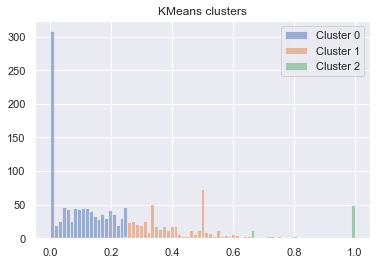

In [42]:
fig, ax = plt.subplots()
label=count['kmeans_labels']
bins = np.linspace(data.min(), data.max(), 80)
for ii in np.unique(label):
    subset = data[label==ii]
    ax.hist(subset, bins=bins, alpha=0.5, label=f"Cluster {ii}")
ax.legend()
ax.set_title("KMeans clusters")
plt.show()

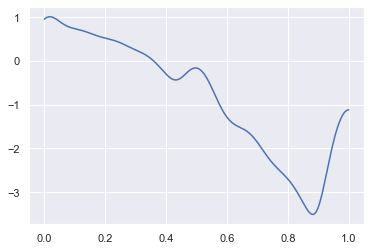

In [43]:
# kernel density estimate
# estimate of the D-dimensional probability distribution which that data is drawn from
# from numpy import array, linspace
# from sklearn.neighbors import KernelDensity
a=data
kde=KernelDensity(kernel='gaussian', bandwidth=0.04).fit(a)
s = np.linspace(a.min(), a.max(), len(a))   
e = kde.score_samples(s.reshape(-1,1))
plt.plot(s, e)

In [44]:
# from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print ("Minima:", s[mi])
print ("Maxima:", s[ma])

Minima: [0.43146214 0.88185379]
Maxima: [0.01762402 0.49608355 0.99934726]


In [45]:
#   a[a < s[mi][0]]
#   a[(a >= s[mi][0]) * (a <= s[mi][1])]
#   a[a >= s[mi][1]]

def kdelabel(x):
    if x in a[a < s[mi][0]]:
        return 2
    elif x in a[(a >= s[mi][0]) * (a <= s[mi][1])]:
        return 1
    else:
        return 0
    
count['kde_labels'] = count['cancel_rate'].apply(kdelabel)
count

,freq,cancel_freq,cancel_rate,client_id,kmeans_labels,kde_labels
Client Id,,,,,,
140,2,2,1.000000,140,2,0
157,6,0,0.000000,157,0,2
176,13,3,0.230769,176,0,2
224,7,6,0.857143,224,2,1
269,220,47,0.213636,269,0,2
...,...,...,...,...,...,...
20919,2,0,0.000000,20919,0,2
20939,8,0,0.000000,20939,0,2
20942,2,0,0.000000,20942,0,2


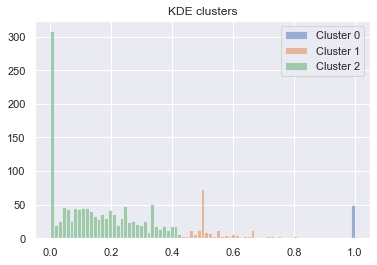

In [46]:
fig, ax = plt.subplots()
label=count['kde_labels']
for ii in np.unique(label):
    subset = data[label==ii]
    ax.hist(subset, bins=bins, alpha=0.5, label=f"Cluster {ii}")
ax.legend()
ax.set_title("KDE clusters")
plt.show()

In [47]:
df=pd.merge(df, count, how='left', on=['Client Id'])
df

,Run Name,Ev Order,Client Id,Date,Creation_Date,Modified Date,Modified Time,Request,Negotiated,Subtype,...,num_CLI,num_1GU,total_pass,need_lift,freq,cancel_freq,cancel_rate,client_id,kmeans_labels,kde_labels
0,0.0,0,19943,2021-05-17,2021-05-10,2021-05-16,21:35:00,59400,59400,REG,...,1,0,1,1,172,43,0.250000,19943,0,2
1,0.0,0,15829,2021-05-17,2021-05-10,2021-05-17,13:54:00,54900,54900,REG,...,1,0,1,0,282,110,0.390071,15829,1,2
2,0.0,0,19943,2021-05-17,2021-05-10,2021-05-16,21:38:00,40800,40800,REG,...,1,0,1,1,172,43,0.250000,19943,0,2
3,0.0,0,13737,2021-05-17,2021-05-10,2021-05-12,9:22,29400,29400,REG,...,1,0,1,0,296,63,0.212838,13737,0,2
4,0.0,0,16130,2021-05-17,2021-05-10,2021-05-17,7:11,32400,32700,DEM,...,1,0,1,0,196,67,0.341837,16130,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102749,355.0,61290358,4871,2021-12-05,2021-11-29,2021-12-04,13:59:00,61200,61200,DEM,...,1,0,1,0,143,6,0.041958,4871,0,2
102750,355.0,64516090,385,2021-12-05,2021-11-28,2021-12-04,14:38:00,62400,62400,DEM,...,1,0,1,0,459,195,0.424837,385,1,2
102751,355.0,74193571,20939,2021-12-05,2021-11-29,2021-12-04,13:57:00,65700,65700,DEM,...,1,0,1,0,8,0,0.000000,20939,0,2
102752,355.0,80645144,20608,2021-12-05,2021-12-02,2021-12-02,16:08:00,68100,68100,DEM,...,1,0,1,0,207,24,0.115942,20608,0,2


In [48]:
b=df.groupby(['Run_weekday'])['Run_weekday'].count()
b = b.to_frame()
b=b.rename(columns={'Run_weekday': 'freq'}) 
b['total_cancel'] = df.groupby('Run_weekday')['cancel_rate'].sum()
b['avg_cancel'] = b['total_cancel']/b['freq']
b

,freq,total_cancel,avg_cancel
Run_weekday,,,
1,15981,2923.438384,0.182932
2,17533,3326.685090,0.189738
3,19350,3646.860749,0.188468
4,17831,3400.977989,0.190734
5,19030,3630.126243,0.190758
6,7803,1908.540437,0.244591
7,5226,1379.371109,0.263944


In [49]:
#df['Date'] = pd.DatetimeIndex(df['Date'])
c=df.groupby(['Date'])['Date'].count()
c = c.to_frame()
c=c.rename(columns={'Date': 'freq'}) 
c['total_cancel'] = df.groupby('Date')['cancel_rate'].sum()
c['avg_cancel'] = c['total_cancel']/c['freq']
c

,freq,total_cancel,avg_cancel
Date,,,
2021-05-17,590,110.948785,0.188049
2021-05-18,592,116.385341,0.196597
2021-05-19,620,121.953556,0.196699
2021-05-20,660,128.510307,0.194713
2021-05-21,645,122.582652,0.190051
...,...,...,...
2021-12-01,704,122.167575,0.173533
2021-12-02,642,116.518972,0.181494
2021-12-03,744,153.125209,0.205813


# Incorporate weather data

In [50]:
df=pd.merge(df, weather, how='left', on=['Date'])
df

,Run Name,Ev Order,Client Id,Date,Creation_Date,Modified Date,Modified Time,Request,Negotiated,Subtype,...,kde_labels,Max_temp,Min_temp,Avg_temp,temp_departure,HDD,CDD,Precipitation,New_snow,Snow_depth
0,0.0,0,19943,2021-05-17,2021-05-10,2021-05-16,21:35:00,59400,59400,REG,...,2,75,49,62.0,2.7,3,0,0.0,0.0,0
1,0.0,0,15829,2021-05-17,2021-05-10,2021-05-17,13:54:00,54900,54900,REG,...,2,75,49,62.0,2.7,3,0,0.0,0.0,0
2,0.0,0,19943,2021-05-17,2021-05-10,2021-05-16,21:38:00,40800,40800,REG,...,2,75,49,62.0,2.7,3,0,0.0,0.0,0
3,0.0,0,13737,2021-05-17,2021-05-10,2021-05-12,9:22,29400,29400,REG,...,2,75,49,62.0,2.7,3,0,0.0,0.0,0
4,0.0,0,16130,2021-05-17,2021-05-10,2021-05-17,7:11,32400,32700,DEM,...,2,75,49,62.0,2.7,3,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102749,355.0,61290358,4871,2021-12-05,2021-11-29,2021-12-04,13:59:00,61200,61200,DEM,...,2,49,27,38.0,3.1,27,0,0.0,0.0,0
102750,355.0,64516090,385,2021-12-05,2021-11-28,2021-12-04,14:38:00,62400,62400,DEM,...,2,49,27,38.0,3.1,27,0,0.0,0.0,0
102751,355.0,74193571,20939,2021-12-05,2021-11-29,2021-12-04,13:57:00,65700,65700,DEM,...,2,49,27,38.0,3.1,27,0,0.0,0.0,0
102752,355.0,80645144,20608,2021-12-05,2021-12-02,2021-12-02,16:08:00,68100,68100,DEM,...,2,49,27,38.0,3.1,27,0,0.0,0.0,0


In [51]:
t=df.groupby(['Avg_temp'])['Avg_temp'].count()
t = t.to_frame()
t=t.rename(columns={'Avg_temp': 'freq'}) 
t['total_cancel'] = df.groupby('Avg_temp')['cancel_rate'].sum()
t['avg_cancel'] = t['total_cancel']/t['freq']
t['temperature'] = t.index.values.tolist()
t.head()

,freq,total_cancel,avg_cancel,temperature
Avg_temp,,,,
30.0,218,51.289812,0.235274,30.0
30.5,680,121.297212,0.178378,30.5
31.5,142,41.517863,0.292379,31.5
32.0,602,100.720512,0.167310,32.0
33.5,616,110.252136,0.178981,33.5


# Data visualization

# Temperature

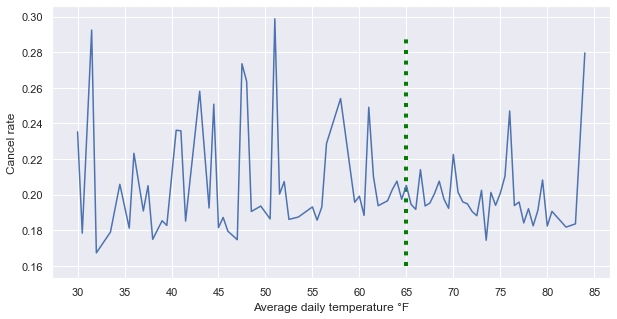

In [52]:
plt.figure(figsize=(10,5))
plt.plot(t.index, t.avg_cancel)
plt.rc('axes', labelsize=20)
#plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.xlabel("Average daily temperature °F")
plt.ylabel("Cancel rate")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.vlines(x=65, ymin=0.16, ymax=0.29, colors="green", lw=4, ls=':')
#vlines(x=39.25, ymin=25, ymax=150, colors='green', ls=':', lw=2, label='vline_single - partial height')


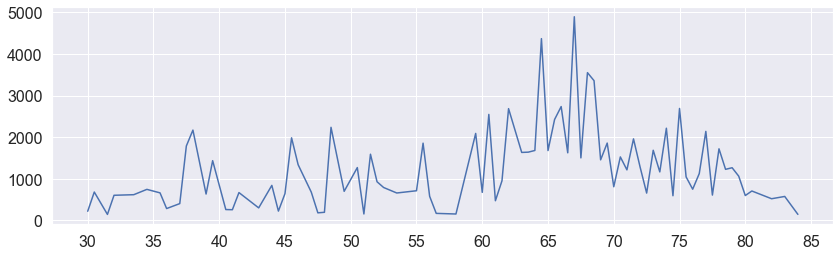

In [53]:
plt.figure(figsize=(14,4))
plt.plot(t.index, t.freq)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))

# Precipitation

In [54]:
p=df.groupby(['Precipitation'])['Precipitation'].count()
p = p.to_frame()
p=p.rename(columns={'Precipitation': 'freq'}) 
p['total_cancel'] = df.groupby('Precipitation')['cancel_rate'].sum()
p['avg_cancel'] = p['total_cancel']/p['freq']

In [55]:
def rain_group(x):
    if x > 0:
        return 1
    else:
        return 0
p['rain'] = p.index.values.tolist()
p['rain_group'] = p['rain'].apply(rain_group)
p

,freq,total_cancel,avg_cancel,rain,rain_group
Precipitation,,,,,
0.00,58066,11393.305864,0.196213,0.00,0
0.01,5031,989.513796,0.196683,0.01,1
0.02,1693,399.400293,0.235913,0.02,1
0.03,1942,385.004391,0.198251,0.03,1
0.04,1583,299.059779,0.188920,0.04,1
0.05,1414,277.772365,0.196444,0.05,1
0.06,220,53.018627,0.240994,0.06,1
0.07,1746,346.269288,0.198321,0.07,1
0.08,3354,645.017273,0.192313,0.08,1


Text(0, 0.5, 'Cancel rate')

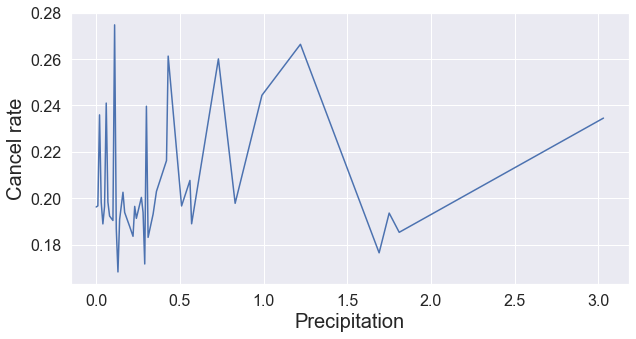

In [56]:
plt.figure(figsize=(10,5))
plt.plot(p.index, p.avg_cancel)
plt.rc('axes', labelsize=20)
#plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
#plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.xlabel("Precipitation")
plt.ylabel("Cancel rate")

In [57]:
data=t[['avg_cancel','temperature']].values  # Series.values = array
kmeans.fit(data)
t['temp_labels']=kmeans.labels_
t['temp_labels'].value_counts()

2    32
0    26
1    25
Name: temp_labels, dtype: int64

Text(0, 0.5, 'Cancel rate')

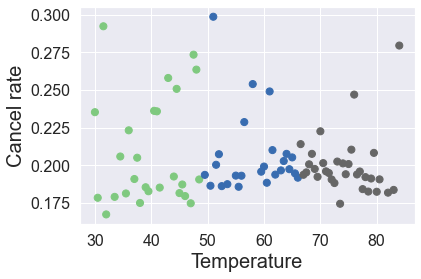

In [58]:
plt.scatter(data[:, 1], data[:, 0], c=t['temp_labels'],
            s=50, cmap="Accent");
plt.xlabel('Temperature')
plt.ylabel('Cancel rate')

In [59]:
def temp_group(x):
    if x < 60:
        return 0
    elif 60 <= x <= 75:
        return 1
    else:
        return 2
    
t['temp_group'] = t['temperature'].apply(temp_group)
t

,freq,total_cancel,avg_cancel,temperature,temp_labels,temp_group
Avg_temp,,,,,,
30.0,218,51.289812,0.235274,30.0,0,0
30.5,680,121.297212,0.178378,30.5,0,0
31.5,142,41.517863,0.292379,31.5,0,0
32.0,602,100.720512,0.167310,32.0,0,0
33.5,616,110.252136,0.178981,33.5,0,0
...,...,...,...,...,...,...
80.0,596,108.693530,0.182372,80.0,2,2
80.5,705,134.381597,0.190612,80.5,2,2
82.0,519,94.340019,0.181773,82.0,2,2


In [60]:
s=df.groupby(['New_snow'])['New_snow'].count()
s = s.to_frame()
s=s.rename(columns={'New_snow': 'freq'}) 
s['total_cancel'] = df.groupby('New_snow')['cancel_rate'].sum()
s['avg_cancel'] = s['total_cancel']/s['freq']
s['snow'] = s.index.values.tolist()
s

,freq,total_cancel,avg_cancel,snow
New_snow,,,,
0.0,99668,19666.251767,0.197318,0.0
0.3,1004,177.440179,0.176733,0.3
0.4,1260,209.492979,0.166264,0.4
1.2,142,41.517863,0.292379,1.2
1.3,680,121.297212,0.178378,1.3


In [61]:
def snow_group(x):
    if x > 0:
        return 1
    else:
        return 0
    
s['snow_group'] = s['snow'].apply(snow_group)
s

,freq,total_cancel,avg_cancel,snow,snow_group
New_snow,,,,,
0.0,99668,19666.251767,0.197318,0.0,0
0.3,1004,177.440179,0.176733,0.3,1
0.4,1260,209.492979,0.166264,0.4,1
1.2,142,41.517863,0.292379,1.2,1
1.3,680,121.297212,0.178378,1.3,1


# merge groups into dataframe

In [62]:
addt = t[['temp_group']]
adds = s[['snow_group']]
addp = p[['rain_group']]
df=pd.merge(df, addt, how='left',on='Avg_temp')
df=pd.merge(df, adds, how='left',on='New_snow')
df=pd.merge(df, addp, how='left',on='Precipitation')
df

,Run Name,Ev Order,Client Id,Date,Creation_Date,Modified Date,Modified Time,Request,Negotiated,Subtype,...,Avg_temp,temp_departure,HDD,CDD,Precipitation,New_snow,Snow_depth,temp_group,snow_group,rain_group
0,0.0,0,19943,2021-05-17,2021-05-10,2021-05-16,21:35:00,59400,59400,REG,...,62.0,2.7,3,0,0.0,0.0,0,1,0,0
1,0.0,0,15829,2021-05-17,2021-05-10,2021-05-17,13:54:00,54900,54900,REG,...,62.0,2.7,3,0,0.0,0.0,0,1,0,0
2,0.0,0,19943,2021-05-17,2021-05-10,2021-05-16,21:38:00,40800,40800,REG,...,62.0,2.7,3,0,0.0,0.0,0,1,0,0
3,0.0,0,13737,2021-05-17,2021-05-10,2021-05-12,9:22,29400,29400,REG,...,62.0,2.7,3,0,0.0,0.0,0,1,0,0
4,0.0,0,16130,2021-05-17,2021-05-10,2021-05-17,7:11,32400,32700,DEM,...,62.0,2.7,3,0,0.0,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102749,355.0,61290358,4871,2021-12-05,2021-11-29,2021-12-04,13:59:00,61200,61200,DEM,...,38.0,3.1,27,0,0.0,0.0,0,0,0,0
102750,355.0,64516090,385,2021-12-05,2021-11-28,2021-12-04,14:38:00,62400,62400,DEM,...,38.0,3.1,27,0,0.0,0.0,0,0,0,0
102751,355.0,74193571,20939,2021-12-05,2021-11-29,2021-12-04,13:57:00,65700,65700,DEM,...,38.0,3.1,27,0,0.0,0.0,0,0,0,0
102752,355.0,80645144,20608,2021-12-05,2021-12-02,2021-12-02,16:08:00,68100,68100,DEM,...,38.0,3.1,27,0,0.0,0.0,0,0,0,0


## Rain 

<ipython-input-63-8ede2d58e6c7>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar1.set_yticklabels(bar1.get_yticks(), size = 16)


[Text(0, 10.0, '10.0'),
 Text(0, 15.0, '15.0'),
 Text(0, 20.0, '20.0'),
 Text(0, 25.0, '25.0'),
 Text(0, 30.0, '30.0'),
 Text(0, 35.0, '35.0'),
 Text(0, 40.0, '40.0')]

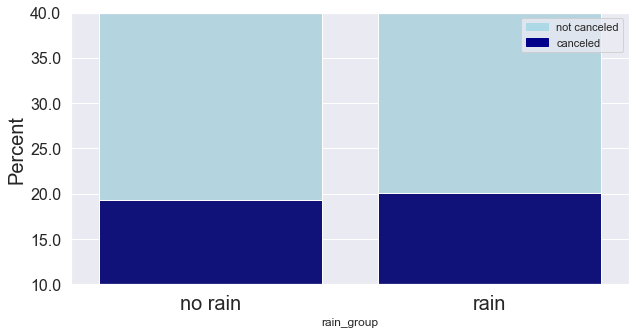

In [63]:
x='rain_group'

total = df.groupby(x)['canceled'].count().to_frame()
canceled = df.loc[df.canceled==1].groupby(x)['canceled'].sum().reset_index()
total[x] = total.index.values.tolist()
canceled['Percent'] = [i / j * 100 for i,j in zip(canceled['canceled'], total['canceled'])]
total['Percent'] = [i / j * 100 for i,j in zip(total['canceled'], total['canceled'])]
sns.set(rc={'figure.figsize':(10,5)})
bar1 = sns.barplot(x=x,  y="Percent", data=total, color='lightblue')
bar2 = sns.barplot(x=x, y="Percent", data=canceled, color='darkblue')

# add legend
top_bar = mpatches.Patch(color='lightblue', label='not canceled')
bottom_bar = mpatches.Patch(color='darkblue', label='canceled')
plt.legend(handles=[top_bar, bottom_bar], loc="upper right")
plt.ylim((10,40))
bar1.set_ylabel("Percent", size = 20)
bar1.set_xticklabels(['no rain', 'rain'], fontsize = 20)
bar1.set_yticklabels(bar1.get_yticks(), size = 16)

## Snow

Text(0.5, 0, 'snow')

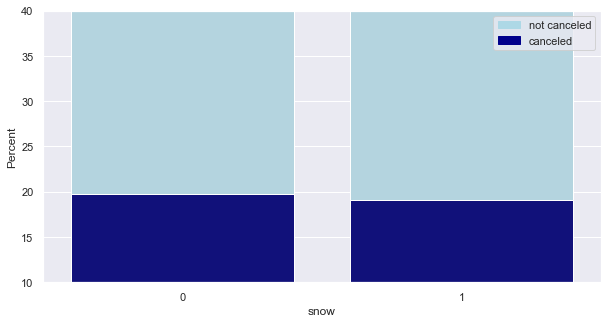

In [64]:
x='snow_group'

total = df.groupby(x)['canceled'].count().to_frame()
canceled = df.loc[df.canceled==1].groupby(x)['canceled'].sum().reset_index()
total[x] = total.index.values.tolist()
canceled['Percent'] = [i / j * 100 for i,j in zip(canceled['canceled'], total['canceled'])]
total['Percent'] = [i / j * 100 for i,j in zip(total['canceled'], total['canceled'])]
sns.set(rc={'figure.figsize':(10,5)})
bar1 = sns.barplot(x=x,  y="Percent", data=total, color='lightblue')
bar2 = sns.barplot(x=x, y="Percent", data=canceled, color='darkblue')

# add legend
top_bar = mpatches.Patch(color='lightblue', label='not canceled')
bottom_bar = mpatches.Patch(color='darkblue', label='canceled')
plt.legend(handles=[top_bar, bottom_bar], loc="upper right")
plt.ylim((10,40))
bar1.set_xlabel("snow")

Text(0, 0.5, 'Cancel rate')

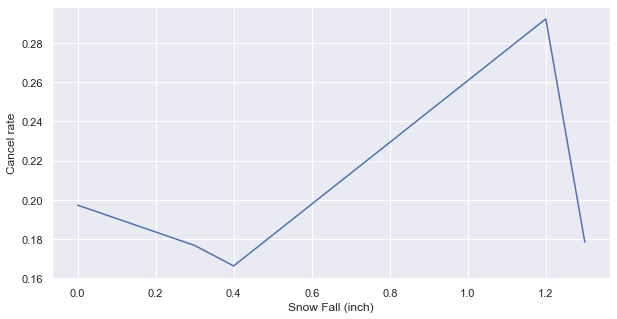

In [65]:
plt.figure(figsize=(10,5))
plt.plot(s.index, s.avg_cancel)
plt.rc('axes', labelsize=20)
#plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.xlabel("Snow Fall (inch)")
plt.ylabel("Cancel rate")

Text(0.5, 0, 'Snow')

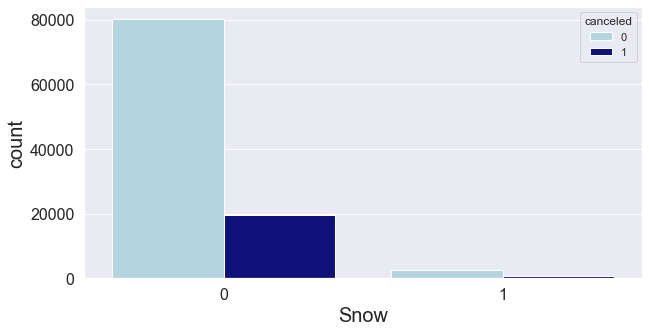

In [66]:
p = sns.countplot(x="snow_group", hue="canceled", data=df, palette=['lightblue',"darkblue"])
p.set_xlabel("Snow")

# Time Series Pattern

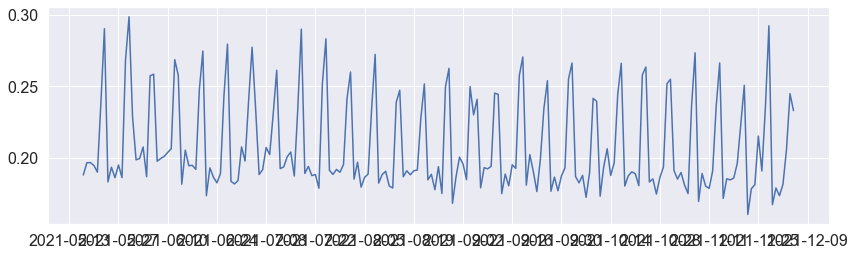

In [67]:
# import matplotlib.ticker as ticker
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(14,4))
plt.plot(c.index, c.avg_cancel)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(14))

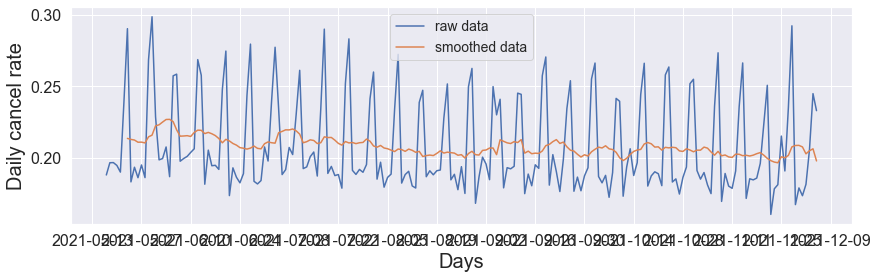

In [68]:
# moving average window = 7, cancel out seasonality
c['7MA'] = c['avg_cancel'].rolling(7).mean()
plt.figure(figsize=(14,4))
plt.plot(c.index, c.avg_cancel, label='raw data')
plt.plot(c.index, c['7MA'], label='smoothed data')
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=13)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.xlabel("Days")
plt.ylabel("Daily cancel rate")
plt.legend()

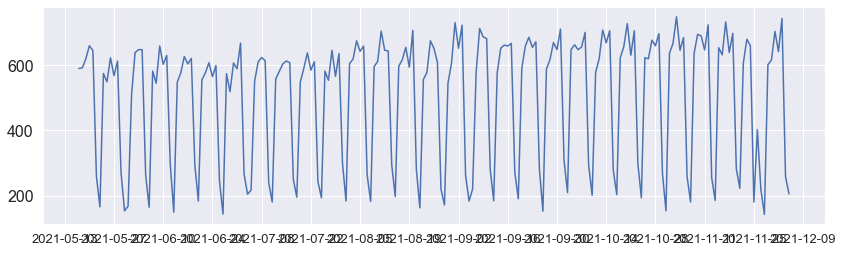

In [69]:
plt.figure(figsize=(14,4))
plt.plot(c.index, c.freq)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(14))

<ipython-input-70-645cf6268a07>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['30MA'] = c['7MA'].rolling(30).mean()


Text(0, 0.5, 'Daily cancel rate')

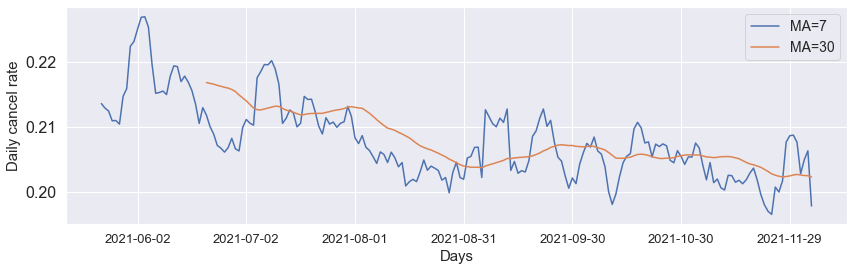

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose
c=c.dropna()
c['30MA'] = c['7MA'].rolling(30).mean()
plt.figure(figsize=(14,4))
plt.plot(c.index, c['7MA'], label='MA=7')
plt.plot(c.index, c['30MA'], label='MA=30')
plt.legend()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.xlabel("Days")
plt.ylabel("Daily cancel rate")

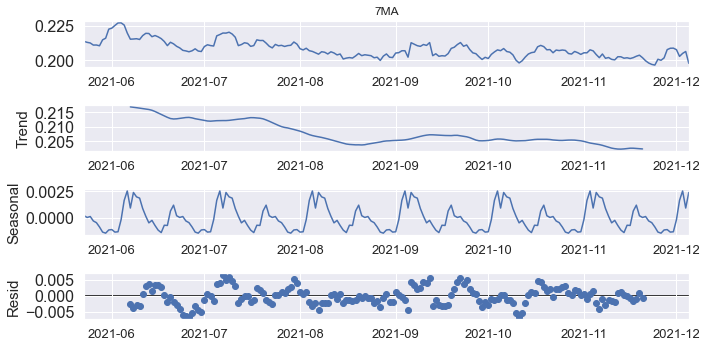

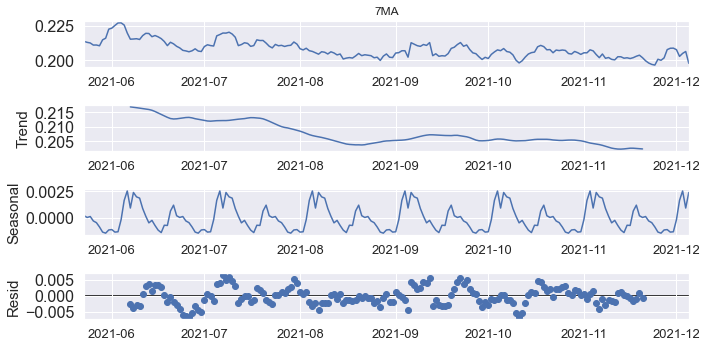

In [71]:
result = seasonal_decompose(c['7MA'], model='additive', period=30)
result.plot()

# Temperature group

[Text(0, 0, 'Cooler zone'),
 Text(1, 0, 'Comfort zone'),
 Text(2, 0, 'Warmer zone')]

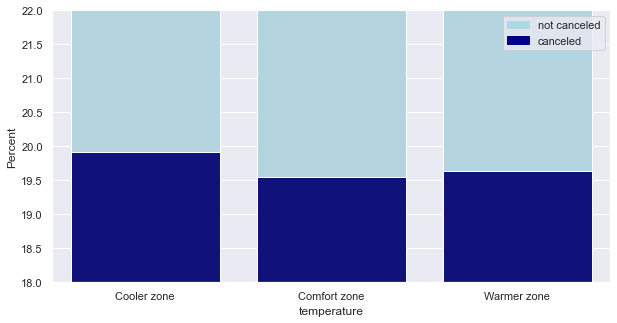

In [72]:
x='temp_group'

total = df.groupby(x)['canceled'].count().to_frame()
canceled = df.loc[df.canceled==1].groupby(x)['canceled'].sum().reset_index()
total[x] = total.index.values.tolist()
canceled['Percent'] = [i / j * 100 for i,j in zip(canceled['canceled'], total['canceled'])]
total['Percent'] = [i / j * 100 for i,j in zip(total['canceled'], total['canceled'])]
sns.set(rc={'figure.figsize':(10,5)})
bar1 = sns.barplot(x=x,  y="Percent", data=total, color='lightblue')
bar2 = sns.barplot(x=x, y="Percent", data=canceled, color='darkblue')

# add legend
top_bar = mpatches.Patch(color='lightblue', label='not canceled')
bottom_bar = mpatches.Patch(color='darkblue', label='canceled')
plt.legend(handles=[top_bar, bottom_bar], loc="upper right")
plt.ylim((18,22))
bar1.set_xlabel("temperature")
bar1.set_xticklabels(['Cooler zone','Comfort zone','Warmer zone'])

In [73]:
# p = sns.countplot(x="temp_group", hue="canceled", data=df, palette=['lightblue',"darkblue"])
# p.set_xlabel("Temperature group")

In [74]:
df['temp_group'].value_counts()

1    57496
0    31790
2    13468
Name: temp_group, dtype: int64

# Reservation in advance

Text(0.5, 0, 'Reservation in advance')

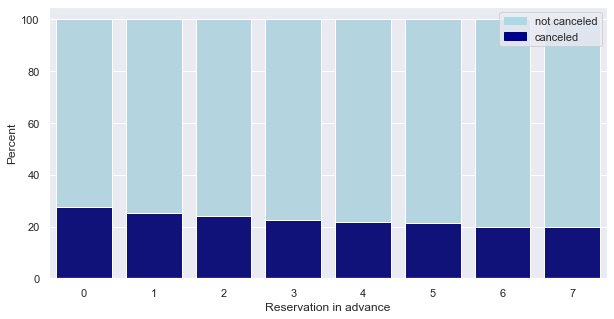

In [75]:
import matplotlib.patches as mpatches
df_advance = df[(df["Subtype"] != 'REG')]
x='diff'
total = df_advance.groupby(x)['canceled'].count().to_frame()
canceled = df_advance.loc[df_advance.canceled==1].groupby(x)['canceled'].sum().reset_index()
total[x] = total.index.values.tolist()
canceled['Percent'] = [i / j * 100 for i,j in zip(canceled['canceled'], total['canceled'])]
total['Percent'] = [i / j * 100 for i,j in zip(total['canceled'], total['canceled'])]
sns.set(rc={'figure.figsize':(10,5)})
bar1 = sns.barplot(x=x,  y="Percent", data=total, color='lightblue')
bar2 = sns.barplot(x=x, y="Percent", data=canceled, color='darkblue')

# add legend
top_bar = mpatches.Patch(color='lightblue', label='not canceled')
bottom_bar = mpatches.Patch(color='darkblue', label='canceled')
plt.legend(handles=[top_bar, bottom_bar], loc="upper right")

bar1.set_xlabel("Reservation in advance")

Text(0.5, 0, 'Reservation in advance')

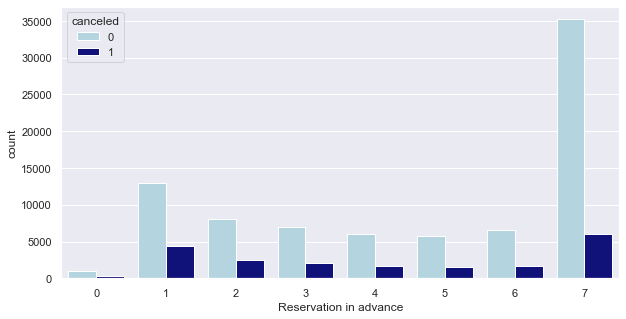

In [76]:
p = sns.countplot(x="diff", hue="canceled", data=df, palette=['lightblue',"darkblue"])
p.set_xlabel("Reservation in advance")

# Trip purpose

[Text(0, 0, 'Demand trip'),
 Text(1, 0, 'Same day trip'),
 Text(2, 0, 'Subscription trip'),
 Text(3, 0, 'Supplemental trip'),
 Text(4, 0, 'Online booked trip')]

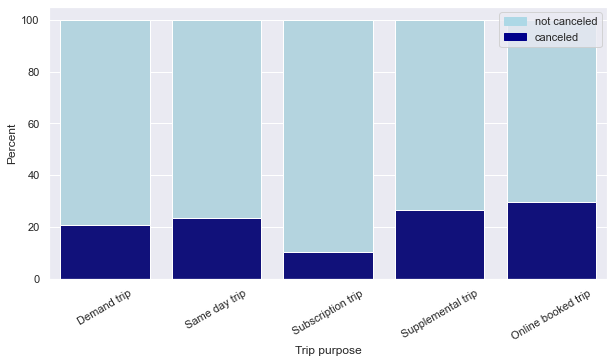

In [77]:
x = 'Subtype'
total = df.groupby(x)['canceled'].count().to_frame()
canceled = df.loc[df.canceled==1].groupby(x)['canceled'].sum().reset_index()
total[x] = total.index.values.tolist()
canceled['Percent'] = [i / j * 100 for i,j in zip(canceled['canceled'], total['canceled'])]
total['Percent'] = [i / j * 100 for i,j in zip(total['canceled'], total['canceled'])]
sns.set(rc={'figure.figsize':(10,5)})
bar1 = sns.barplot(x=x,  y="Percent", data=total, color='lightblue')
bar2 = sns.barplot(x=x, y="Percent", data=canceled, color='darkblue')

# add legend
top_bar = mpatches.Patch(color='lightblue', label='not canceled')
bottom_bar = mpatches.Patch(color='darkblue', label='canceled')
plt.legend(handles=[top_bar, bottom_bar], loc="upper right")

#bar1.set_xticklabels(['On weekdays','On weekends'])
bar1.set_xlabel("Trip purpose")
plt.xticks(rotation=30)
bar1.set_xticklabels(['Demand trip','Same day trip','Subscription trip','Supplemental trip','Online booked trip'])


Text(0.5, 0, 'Trip purpose')

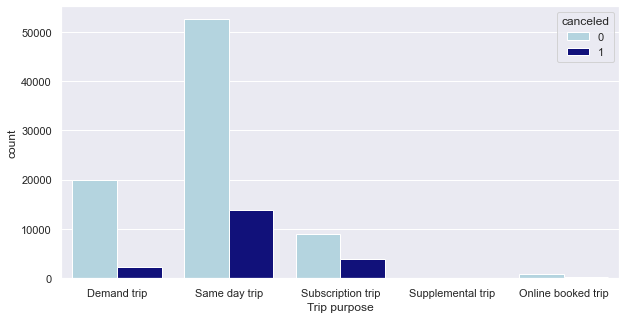

In [78]:
p = sns.countplot(x="Subtype", hue="canceled", data=df, palette=['lightblue',"darkblue"])
#plt.xticks(rotation=30)
#p.set_xticklabels(['On weekdays','On weekends'])
p.set_xticklabels(['Demand trip','Same day trip','Subscription trip','Supplemental trip','Online booked trip'])

p.set_xlabel("Trip purpose")

# Request time

Text(0.5, 0, 'RequestInHour')

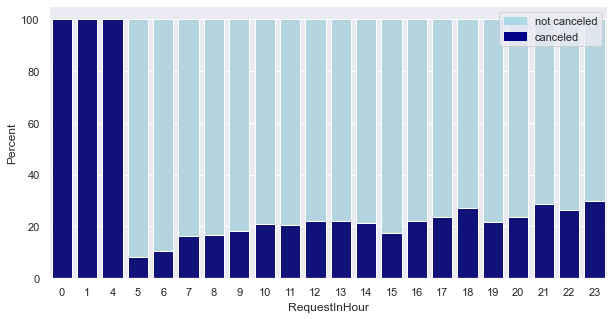

In [79]:
x = 'RequestInHour'
total = df.groupby(x)['canceled'].count().to_frame()
canceled = df.loc[df.canceled==1].groupby(x)['canceled'].sum().reset_index()
total[x] = total.index.values.tolist()
canceled['Percent'] = [i / j * 100 for i,j in zip(canceled['canceled'], total['canceled'])]
total['Percent'] = [i / j * 100 for i,j in zip(total['canceled'], total['canceled'])]
sns.set(rc={'figure.figsize':(10,5)})
bar1 = sns.barplot(x=x,  y="Percent", data=total, color='lightblue')
bar2 = sns.barplot(x=x, y="Percent", data=canceled, color='darkblue')

# add legend
top_bar = mpatches.Patch(color='lightblue', label='not canceled')
bottom_bar = mpatches.Patch(color='darkblue', label='canceled')
plt.legend(handles=[top_bar, bottom_bar], loc="upper right")

#bar1.set_xticklabels(['On weekdays','On weekends'])
bar1.set_xlabel("RequestInHour")
#plt.xticks(rotation=30)
#bar1.set_xticklabels(['Demand trip','Same day trip','Subscription trip','Supplemental trip','Online booked trip'])


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102754 entries, 0 to 102753
Data columns (total 53 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Run Name         102754 non-null  float64       
 1   Ev Order         102754 non-null  int64         
 2   Client Id        102754 non-null  int64         
 3   Date             102754 non-null  datetime64[ns]
 4   Creation_Date    102754 non-null  datetime64[ns]
 5   Modified Date    102754 non-null  datetime64[ns]
 6   Modified Time    102754 non-null  object        
 7   Request          102754 non-null  int64         
 8   Negotiated       102754 non-null  int64         
 9   Subtype          102754 non-null  object        
 10  Sched Status     102754 non-null  int64         
 11  Purpose          102754 non-null  object        
 12  Pass_On          102754 non-null  object        
 13  Space_On         102754 non-null  object        
 14  Direct Distance  102

# PCA

In [81]:
# # from sklearn.decomposition import PCA

# df_fe = df

# # Principal Component Analysis
# pca = PCA(n_components=5)
# # USELESS INFO
# # pca_df = pca.fit_transform(df_fe[['Run_Month', 'Run_Day', 'Run_Year', 'Run_weekday','Request','Negotiated','Pick Zip','Pick Poly','Drop Zip','Drop Poly','Run_weekday']])
# pca_df = pca.fit_transform(df_fe[['Direct Distance','is_weekend','diff', 'RequestInHour','num_PCA','num_child','num_CLI','num_1GU','total_pass','need_lift','freq','cancel_freq','cancel_rate','client_id','kmeans_labels','kde_labels']]) 
# #'num_PCA','num_child','num_CLI','num_1GU','total_pass','need_lift'

# # update dataframe 
# df_fe = pd.concat((df_fe, pd.DataFrame(pca_df)), axis=1)
# df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3',3: 'PCA_4',4: 'PCA_5'}, axis=1, inplace = True)
# # df_fe.drop(['Run_Month', 'Run_Day', 'Run_Year', 'Run_weekday','Request','Negotiated','Pick Zip','Pick Poly','Drop Zip','Drop Poly','Run_weekday'], axis=1, inplace=True)
# df_fe.head()

In [82]:
# df_fe2 = df

# # Principal Component Analysis
# pca2 = PCA(n_components=2)
# #USELESS INFO
# pca_df2 = pca2.fit_transform(df_fe2[['Run_Month', 'Run_Day', 'Run_Year', 'Run_weekday','Request','Negotiated','Run_weekday']])
# # USEFUL INFO
# # pca_df2 = pca2.fit_transform(df_fe2[['Direct Distance','is_weekend','diff', 'RequestInHour','num_PCA','num_child','num_CLI','num_1GU','total_pass','need_lift','freq','cancel_freq','cancel_rate','client_id','kmeans_labels','kde_labels']]) 
# #'num_PCA','num_child','num_CLI','num_1GU','total_pass','need_lift'

# # update dataframe 
# df_fe2 = pd.concat((df_fe2, pd.DataFrame(pca_df2)), axis=1)
# df_fe2.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3',3: 'PCA_4',4: 'PCA_5'}, axis=1, inplace = True)
# # df_fe.drop(['Run_Month', 'Run_Day', 'Run_Year', 'Run_weekday','Request','Negotiated','Pick Zip','Pick Poly','Drop Zip','Drop Poly','Run_weekday'], axis=1, inplace=True)
# df_fe2.head()

In [83]:
# # X = df.drop(columns='canceled').drop(columns='Sched Status').drop(columns='Date').drop(columns='Creation_Date').drop(columns='Modified Date').drop(columns='Modified Time').drop(columns='Run Name').drop(columns='Ev Order').drop(columns=['Request','Negotiated','Client Id','client_id','freq','Pass_On','Space_On','Pick City','Pick Zip','Pick Poly','Drop City','Drop Zip','Drop Poly','Run_weekday'])
# X = df_fe2.drop(columns='canceled').drop(columns='Sched Status').drop(columns='Date').drop(columns='Creation_Date').drop(columns='Modified Date').drop(columns='Modified Time').drop(columns='Run Name').drop(columns='Ev Order').drop(columns='Request').drop(columns='Negotiated').drop(columns='Pick City').drop(columns='Pick Zip').drop(columns='Pick Poly').drop(columns='Drop City').drop(columns='Drop Zip').drop(columns='Drop Poly').drop(columns='Pass_On').drop(columns='Run_Month').drop(columns='Run_Day').drop(columns='Run_Year').drop(columns='Run_weekday').drop(columns='Space_On')
# # X = X.drop(columns=['Direct Distance','is_weekend','diff', 'RequestInHour','num_PCA','num_child','num_CLI','num_1GU','total_pass','need_lift','freq','cancel_freq','cancel_rate','client_id','kmeans_labels','kde_labels'])

# y = df_fe2['canceled']
# X.info()

In [84]:
LE = LabelEncoder()
df['Subtype'] = LE.fit_transform(df['Subtype'])
df['Purpose'] = LE.fit_transform(df['Purpose'])

In [85]:
X = df.drop(columns=['canceled','cancel_freq','Sched Status','Date','Creation_Date','Modified Date','Modified Time','Run Name','Ev Order','Request','Negotiated','Client Id','client_id','freq','Pass_On','Space_On','Pick City','Pick Zip','Pick Poly','Drop City','Drop Zip','Drop Poly','Run_Year','Snow_depth'])
y = df['canceled']

# Train-Test Splitting

In [86]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.20, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (82203, 29), X_test size: (20551, 29)


# Random Oversampling

In [87]:
# from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(X_train, y_train)

# SMOTE 

In [88]:
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTEENN

smote = SMOTE()
# smenn = SMOTEENN()

x_smote, y_smote = smote.fit_resample(X_train, y_train)
# x_smenn, y_smenn = smenn.fit_resample(X, y)

In [89]:
y_train.value_counts()
# X_origin = X
# y_origin = y
# X = x_smote
# y = y_smote
# # X = x_smenn
# # y = y_smenn
# # X = x_ros
# # y = y_ros

0    66002
1    16201
Name: canceled, dtype: int64

In [90]:
# # forest_classifier = BalancedRandomForestClassifier(n_estimators=90, min_samples_leaf=2)
# forest_classifier = RandomForestClassifier(n_estimators=200)
# # cvs_scores = cross_val_score(forest_classifier, X, y, cv=3)
# print("Balanced Random Forest Classifier Accuracy with n_estimators=60 is: {}%".format(round(cvs_scores.mean(), 4)*100))

In [91]:
# feature_names = X.columns()
# plt.figure(figsize=(20,15))
# plt.barh(feature_names, forest_classifier.feature_importances_)

# Random Forest with SMOTE

In [92]:
forest_classifier = RandomForestClassifier(n_estimators=200)
# forest_classifier.fit(X_train,y_train)
# forest_classifier.fit(x_ros, y_ros)
forest_classifier.fit(x_smote, y_smote)
y_pred_1 = forest_classifier.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred_1).sum()))
print("Accuracy rate for the test set: ", (X_test.shape[0]- (y_test != y_pred_1).sum())/X_test.shape[0])
y_pred_proba_1 = forest_classifier.predict_proba(X_test)[:,1]

Number of mislabeled points out of a total 20551 points : 3110
Accuracy rate for the test set:  0.8486691645175417


In [93]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     16536
           1       0.62      0.57      0.60      4015

    accuracy                           0.85     20551
   macro avg       0.76      0.74      0.75     20551
weighted avg       0.84      0.85      0.85     20551



<AxesSubplot:>

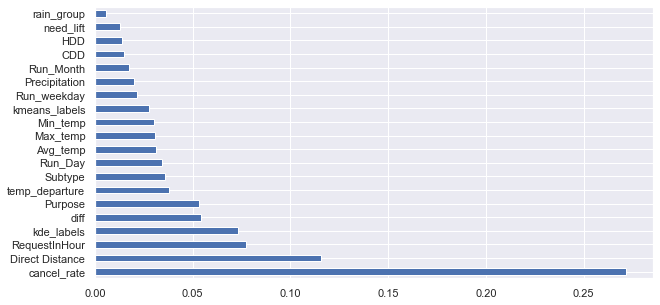

In [94]:
feat_importances = pd.Series(forest_classifier.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [95]:
# from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, y_pred_1)

array([[[ 2290,  1725],
        [ 1385, 15151]],

       [[15151,  1385],
        [ 1725,  2290]]], dtype=int64)

# Weighted Random Forest

In [96]:
balanced_forest_classifier = RandomForestClassifier(n_estimators=200, class_weight="balanced")
balanced_forest_classifier.fit(X_train,y_train)
# balanced_forest_classifier.fit(x_smote, y_smote)
y_pred_3 = balanced_forest_classifier.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred_3).sum()))
print("Accuracy rate for the test set: ", (X_test.shape[0]- (y_test != y_pred_3).sum())/X_test.shape[0])
y_pred_proba_3 = balanced_forest_classifier.predict_proba(X_test)[:,1]

Number of mislabeled points out of a total 20551 points : 2811
Accuracy rate for the test set:  0.8632183348742154


In [97]:
# from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     16536
           1       0.75      0.45      0.56      4015

    accuracy                           0.86     20551
   macro avg       0.81      0.71      0.74     20551
weighted avg       0.85      0.86      0.85     20551



Subtype            0.023724
Purpose            0.048330
Direct Distance    0.122128
Run_Month          0.020621
Run_Day            0.042427
Run_weekday        0.025570
is_weekend         0.004136
diff               0.054869
RequestInHour      0.092775
num_PCA            0.005321
num_child          0.000430
num_CLI            0.000278
num_1GU            0.001806
total_pass         0.006457
need_lift          0.033332
cancel_rate        0.210108
kmeans_labels      0.058014
kde_labels         0.026797
Max_temp           0.036503
Min_temp           0.035675
Avg_temp           0.035996
temp_departure     0.044245
HDD                0.016229
CDD                0.017923
Precipitation      0.022514
New_snow           0.001525
temp_group         0.004707
snow_group         0.000916
rain_group         0.006645
dtype: float64


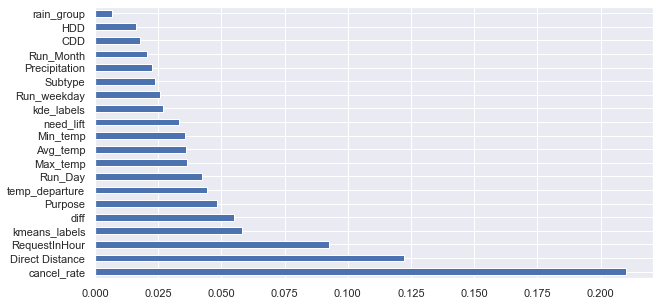

In [98]:
feat_importances = pd.Series(balanced_forest_classifier.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
print(feat_importances)

In [99]:
# from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, y_pred_3)

array([[[ 1807,  2208],
        [  603, 15933]],

       [[15933,   603],
        [ 2208,  1807]]], dtype=int64)

In [100]:
# from sklearn.metrics import precision_score, recall_score
precision_score(y_test, y_pred_3)

0.749792531120332

# xgboost

In [101]:
# fit model no training data
# model = XGBClassifier()
model = XGBClassifier(learning_rate=0.11,
                        n_estimators = 1000,
                        max_depth=10,
                        scale_pos_weight=4)
# model.fit(x_smote, y_smote)
model.fit(X_train, y_train)

# make predictions for test data
y_pred_2 = model.predict(X_test)

#multilabel_confusion_matrix(y_test, y_pred_2)

C:\Users\Mei\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [102]:
# from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     16536
           1       0.65      0.62      0.64      4015

    accuracy                           0.86     20551
   macro avg       0.78      0.77      0.78     20551
weighted avg       0.86      0.86      0.86     20551



Subtype            0.041856
Purpose            0.037294
Direct Distance    0.040035
Run_Month          0.041131
Run_Day            0.036897
Run_weekday        0.036434
is_weekend         0.000000
diff               0.033670
RequestInHour      0.027148
num_PCA            0.039229
num_child          0.039258
num_CLI            0.066502
num_1GU            0.040536
total_pass         0.038931
need_lift          0.115739
cancel_rate        0.105472
kmeans_labels      0.000000
kde_labels         0.000000
Max_temp           0.037324
Min_temp           0.038652
Avg_temp           0.038862
temp_departure     0.038938
HDD                0.000000
CDD                0.000000
Precipitation      0.038244
New_snow           0.067849
temp_group         0.000000
snow_group         0.000000
rain_group         0.000000
dtype: float32


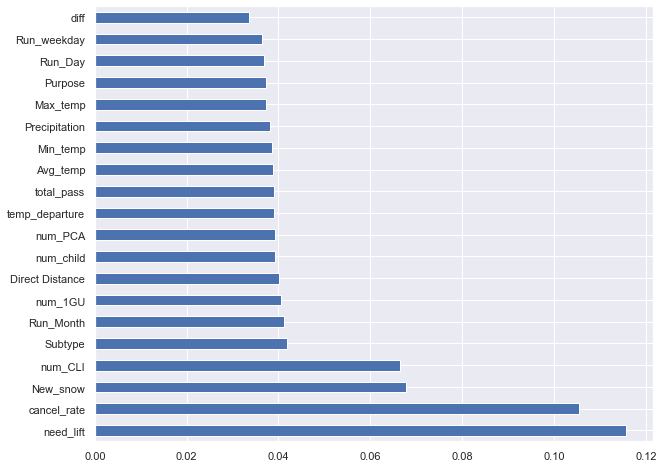

In [103]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,8))
feat_importances.nlargest(20).plot(kind='barh')
print(feat_importances)

In [104]:
multilabel_confusion_matrix(y_test, y_pred_2)

array([[[ 2503,  1512],
        [ 1336, 15200]],

       [[15200,  1336],
        [ 1512,  2503]]], dtype=int64)

# apply to new data

In [105]:
df_test = pd.read_excel(file)

df_test['Run_Month'] = pd.DatetimeIndex(df_test['Date']).month
df_test['Run_Day'] = pd.DatetimeIndex(df_test['Date']).day
df_test['Run_Year'] = pd.DatetimeIndex(df_test['Date']).year
df_test['Run_weekday'] = df_test['Date'].dt.dayofweek
df_test['Run_weekday'] = df_test['Run_weekday'] + 1
df_test['is_weekend'] = df_test['Run_weekday'].apply(weekend)
df_test = df_test.rename(columns={"Creation Date":"Creation_Date"})
diff_test = (pd.to_datetime(df_test.Date) - pd.to_datetime(df_test.Creation_Date)).dt.days
df_test['diff'] = diff_test
df_test = df_test[(df_test["diff"] < 8 )]

df_test['Direct Distance'] = [float(d.replace('mi','')) for d in df_test['Direct Distance']]
df_test['Run Name'] = df_test['Run Name'].fillna(0)
df_test = df_test.dropna()

def cancel(x):
    
    if x == 1 or x == 4 or x== 20 or x==21 or x==30 or x==32 or x==42:
        return 0
    else:
        return 1
    
df_test['canceled'] = df_test['Sched Status'].apply(cancel)
df_test['RequestInHour'] =np.round(df_test['Request']/3600-0.5)

df_test = df_test.rename(columns={"Pass On":"Pass_On"})
df_test["Pass_On"] = df_test.Pass_On.astype(str)
df_test["num_PCA"] = df_test.apply(numOfPCA, axis = 1)
df_test["num_child"] = df_test.apply(numOfChild, axis = 1)
df_test["num_CLI"] = df_test.apply(numOfCLI, axis = 1)
df_test["num_1GU"] = df_test.apply(numOf1GU, axis = 1)
df_test["total_pass"] = df_test["num_PCA"] + df_test["num_child"] + df_test["num_CLI"] + df_test["num_1GU"]
df_test = df_test.rename(columns={"Space On":"Space_On"})
df_test["Space_On"] = df_test.Space_On.astype(str)

df_test["need_lift"] = df_test.apply(needLift, axis = 1)

# cancel rate
a = df_test.groupby(['Client Id'])['Client Id'].count()
count = a.to_frame()
count=count.rename(columns={'Client Id': 'freq'}) 
count["cancel_freq"] = [df_test.loc[(df_test['canceled']==1) & (df_test['Client Id']==i)].count()[0] for i in count.index.values.tolist()]
count['cancel_rate'] = count['cancel_freq'] / count['freq']
count['client_id'] = count.index.values.tolist()
count.sort_values("cancel_rate", ascending=0)

# kmeans
data=count['cancel_rate'].values.reshape(-1, 1)  # Series.values = array
kmeans.fit(data)
count['kmeans_labels']=kmeans.labels_
count['kmeans_labels'].value_counts()
# kde
a=data
kde=KernelDensity(kernel='gaussian', bandwidth=0.04).fit(a)
s = np.linspace(a.min(), a.max(), len(a))  
e = kde.score_samples(s.reshape(-1,1))
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
count['kde_labels'] = count['cancel_rate'].apply(kdelabel)
df_test=pd.merge(df_test, count, how='left', on=['Client Id'])

df_test['Subtype']= LE.fit_transform(df_test['Subtype'])
df_test['Purpose']= LE.fit_transform(df_test['Purpose'])
# df_new = pd.get_dummies(df_new, columns=['Subtype'])
# df_new = pd.get_dummies(df_new, columns=['Purpose'])

df_test=pd.merge(df_test, weather, how='left', on=['Date'])
df_test=pd.merge(df_test, addt, how='left',on='Avg_temp')
df_test=pd.merge(df_test, adds, how='left',on='New_snow')
df_test=pd.merge(df_test, addp, how='left',on='Precipitation')

# # Principal Component Analysis
# pca_new = PCA(n_components=5)
# # pca_df = pca.fit_transform(df_fe[['Run_Month', 'Run_Day', 'Run_Year', 'Run_weekday','Request','Negotiated','Pick Zip','Pick Poly','Drop Zip','Drop Poly','Run_weekday']])
# #useless
# pca_dfnew = pca_new.fit_transform(df_new[['Run_Month', 'Run_Day', 'Run_Year', 'Run_weekday','Request','Negotiated','Pick Zip','Pick Poly','Drop Zip','Drop Poly','Run_weekday']])
# #Useful
# # pca_dfnew = pca_new.fit_transform(df_new[['Direct Distance','is_weekend','diff', 'RequestInHour','num_PCA','num_child','num_CLI','num_1GU','total_pass','need_lift','freq','cancel_freq','cancel_rate','client_id','kmeans_labels','kde_labels']]) 
# #'num_PCA','num_child','num_CLI','num_1GU','total_pass','need_lift'

# # update dataframe 
# df_new = pd.concat((df_new, pd.DataFrame(pca_dfnew)), axis=1)
# df_new.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3',3: 'PCA_4',4: 'PCA_5'}, axis=1, inplace = True)
# # df_fe.drop(['Run_Month', 'Run_Day', 'Run_Year', 'Run_weekday','Request','Negotiated','Pick Zip','Pick Poly','Drop Zip','Drop Poly','Run_weekday'], axis=1, inplace=True)

# X_new = df_new.drop(columns='canceled').drop(columns='Sched Status').drop(columns='Date').drop(columns='Creation_Date').drop(columns='Modified Date').drop(columns='Modified Time').drop(columns='Run Name').drop(columns='Ev Order').drop(columns='Request').drop(columns='Negotiated').drop(columns='Pick City').drop(columns='Pick Zip').drop(columns='Pick Poly').drop(columns='Drop City').drop(columns='Drop Zip').drop(columns='Drop Poly').drop(columns='Pass_On').drop(columns='Run_Month').drop(columns='Run_Day').drop(columns='Run_Year').drop(columns='Run_weekday').drop(columns='Space_On')
# X_new = X_new.drop(columns=['Direct Distance','is_weekend','diff', 'RequestInHour','num_PCA','num_child','num_CLI','num_1GU','total_pass','need_lift','freq','cancel_freq','cancel_rate','client_id','kmeans_labels','kde_labels'])
X_new = df_test.drop(columns=['canceled','cancel_freq','Sched Status','Date','Creation_Date','Modified Date','Modified Time','Run Name','Ev Order','Request','Negotiated','Client Id','client_id','freq','Pass_On','Space_On','Pick City','Pick Zip','Pick Poly','Drop City','Drop Zip','Drop Poly','Run_Year','Snow_depth'])
y_new = df_test['canceled']
X_new.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21886 entries, 0 to 21885
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Subtype          21886 non-null  int32  
 1   Purpose          21886 non-null  int32  
 2   Direct Distance  21886 non-null  float64
 3   Run_Month        21886 non-null  int64  
 4   Run_Day          21886 non-null  int64  
 5   Run_weekday      21886 non-null  int64  
 6   is_weekend       21886 non-null  int64  
 7   diff             21886 non-null  int64  
 8   RequestInHour    21886 non-null  float64
 9   num_PCA          21886 non-null  int64  
 10  num_child        21886 non-null  int64  
 11  num_CLI          21886 non-null  int64  
 12  num_1GU          21886 non-null  int64  
 13  total_pass       21886 non-null  int64  
 14  need_lift        21886 non-null  int64  
 15  cancel_rate      21886 non-null  float64
 16  kmeans_labels    21886 non-null  int32  
 17  kde_labels  

In [106]:
y_pred_new = forest_classifier.predict(X_new)
print("Number of mislabeled points out of a total %d points : %d" % (X_new.shape[0], (y_new != y_pred_new).sum()))
print("Accuracy rate for the test set: ", (X_new.shape[0]- (y_new != y_pred_new).sum())/X_new.shape[0])

Number of mislabeled points out of a total 21886 points : 3277
Accuracy rate for the test set:  0.8502695787261263


In [107]:
precision_score(y_new, y_pred_new)

0.6099357763505856

In [108]:
print(classification_report(y_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     17445
           1       0.61      0.73      0.66      4441

    accuracy                           0.85     21886
   macro avg       0.77      0.80      0.78     21886
weighted avg       0.86      0.85      0.85     21886



In [109]:
def result(x):
    if x == 1 :
        return 'Cancel'
    else:
        return 'Not Cancel'

In [110]:
y_pred_new_busy = balanced_forest_classifier.predict(X_new)
y_pred_new_non_busy = model.predict(X_new)

# Export Result

In [111]:
df_result = df_test[['Run Name']]
df_result['Ev Order']= df_test['Ev Order']
df_result['Client Id']= df_test['Client Id']
df_result['Date']= df_test['Date']
df_result['Negotiated Time'] = [str(dt.timedelta(seconds=i)) for i in df_test['Negotiated']]
df_result['Negotiated'] = df_test['Negotiated']

df_result['Prediction_busy']= y_pred_new_busy
df_result['Prediction_not_busy']= y_pred_new_non_busy

df_result['Prediction'] = df_result['Prediction_busy']
df_result.loc[df_result['Negotiated']<28800 , 'Prediction'] = df_result['Prediction_not_busy']
df_result.loc[df_result['Negotiated']>54000 , 'Prediction'] = df_result['Prediction_not_busy']
df_result['actual'] = y_new
print(classification_report(y_new, df_result['Prediction']))

df_result['Prediction']=df_result['Prediction'].apply(result)
df_result = df_result.drop(columns = ['actual','Negotiated','Prediction_busy','Prediction_not_busy'])

<ipython-input-111-76292fc28b28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['Ev Order']= df_test['Ev Order']
<ipython-input-111-76292fc28b28>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['Client Id']= df_test['Client Id']
<ipython-input-111-76292fc28b28>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     17445
           1       0.79      0.58      0.67      4441

    accuracy                           0.88     21886
   macro avg       0.85      0.77      0.80     21886
weighted avg       0.88      0.88      0.88     21886



In [112]:
# Change the file location here for saving the prediction result
df_result.to_csv(r'C:\Users\Mei\Desktop\Academic\DSC383W\project_test\Result.csv',index = False, header=True)